In [2]:
import sys
sys.path.insert(0, "../../../")


# MNIST Classification

We will build a neural network to classify images and apply it to the classical problem of the classification of the hand-written digits in the MNIST dataset (a must for everyone working with deep learning).
In this application, we will do this using a _fully connected neural network_ (a.k.a. _multi-layer perceptron_ or _dense neural network_), even though convolutional neural networks would be more appropriate.
We will also introduce the \emph{confusion matrix}, a common graphical tool used to gain insights into the performance of a classification algorithm.


### The MNIST dataset

Recognizing the handwritten digits of the MNIST dataset is a classical benchmark for machine learning. The task consists of recognizing handwritten digits from 0 to 9 in 28x28 pixel images. In the dataset, there are 6 * 10^4 training images and 10^4 test images.


### Training data

To import the images of the MNIST dataset into Python, we can download them using the package `torchvision`.


In [3]:
import torchvision

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

Let us visualize some of the MNIST digits.
By visually inspecting them, we can check that the digits have been correctly imported and that the ground-truth labels are correct.

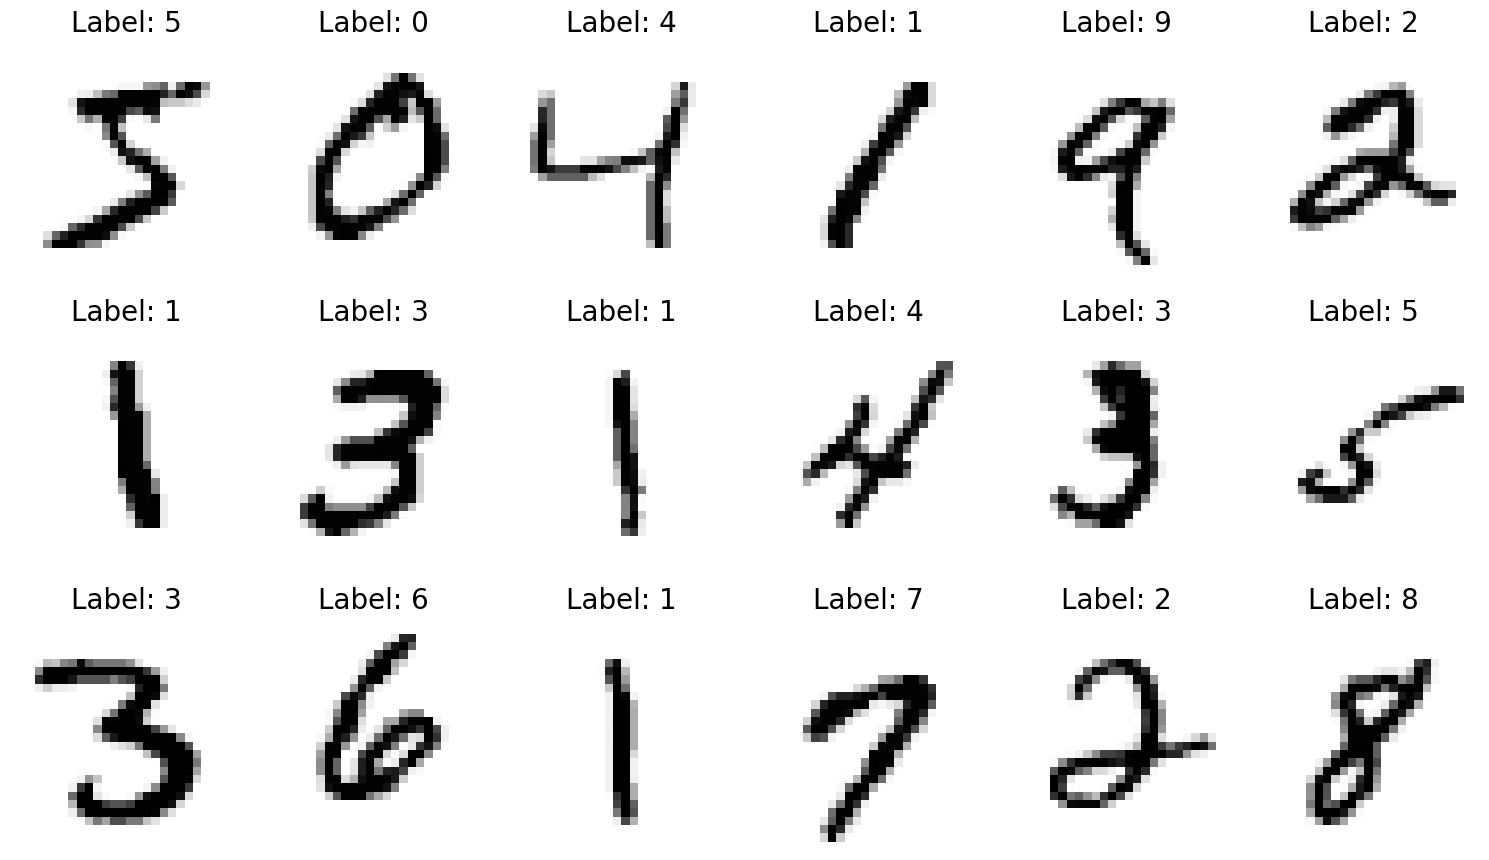

In [4]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 9))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    training_data, training_groundtruths = mnist_train[i]
    plt.title(f"Label: {training_groundtruths}", fontsize=20)
    plt.imshow(training_data.squeeze(), cmap="Greys") 
    plt.axis("off")

plt.tight_layout()
plt.show()

## PyTorch Neural network

We will now define the neural network used to classify the digits. There are many modern libraries that make defining and training neural networks much easier (but less istructive!) than doing it from scratch. The main ones are `PyTorch`, `TensorFlow`, and `Keras`. Each has its own advantages. `PyTorch`~and `TensorFlow`~both offer deep low-level access, with `PyTorch`~offering a functional style approach, while `TensorFlow`~has a more object-oriented flavor. In `Keras`~many details are abstracted away, making defining and training networks easier. In this application, we will be using an extension of `PyTorch`, `deeplay`, which offers a high-level interface while still allowing low-level access. This will allow us to focus on the concepts rather than the details of the implementation. However, we will first show how to do the same thing in `PyTorch`.

We will start with a small _fully connected neural network_ (often called also a _multi-layer perceptron_ or a _dense neural network_) with two hidden layers with 32 neurons each. 
Although not optimal (why this is will be discussed later in this application), we will use the _sigmoid_ function as the activation function for both hidden layers and the output layer. The output layer will have 10 neurons, one for each digit. Due to the _sigmoid_ activation on the output, the output of the network will be a vector of 10 numbers between 0 and 1, which can be interpreted as probabilities. The predicted digit will be the one with the highest probability.

In [5]:
import torch

# Define the model
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 32),
    torch.nn.Sigmoid(),
    torch.nn.Linear(32, 32),
    torch.nn.Sigmoid(),
    torch.nn.Linear(32, 10),
    torch.nn.Sigmoid(),
)

print("Number of parameters:", sum(p.numel() for p in model.parameters()))
print(model)




Number of parameters: 26506
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=32, out_features=10, bias=True)
  (6): Sigmoid()
)


Next, we need to define a _loss function_ and an _optimizer_.

In [6]:
loss_function = torch.nn.MSELoss() # Mean Squared Error loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # Stochastic Gradient Descent optimizer

Finally, in `PyTorch`~we need to define a training loop. In this loop, we will first compute the output of the network for the current batch of images, then compute the loss, and finally update the parameters of the network using the optimizer. We will also compute the accuracy of the network on the training set at each epoch. We start by difining a function to evaluate the network on the test set.

In [8]:
import tqdm 
def evaluate(model, dataset):
    correct = 0
    total = len(dataset)
    with torch.no_grad():
        for image, true_digit in tqdm.notebook.tqdm(dataset):
            probabilities = model(image)
            _, predicted_digit = torch.max(probabilities.data, -1)
            correct += (predicted_digit == true_digit)
    return (correct / total).item() * 100

print("Accuracy on test set before training:", evaluate(model, mnist_test), "%")

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy on test set before training: 11.349999904632568 %


Now we can define the training loop. 

In [7]:
def train_step(model, image, true_digit, loss_function, optimizer):

    # We need to convert the true_digit to a one-hot vector. 
    # This is a 10-dimensional vector, where the true digit is 1 and all other digits are 0.
    one_hot_true_digit = torch.zeros(10).float()
    one_hot_true_digit[true_digit] = 1

    # We need to set the gradients to zero before starting to do backpropragation to avoid
    # gradient accumulation between the steps.
    optimizer.zero_grad()
    
    # Forward pass
    probabilities = model(image).squeeze()

    # Compute the loss
    loss = loss_function(probabilities, one_hot_true_digit)

    # Backward pass
    loss.backward()

    # Update the parameters
    optimizer.step()

    return loss.item()

for step_index, (image, true_digit) in enumerate(mnist_train):

    loss = train_step(model, image, true_digit, loss_function, optimizer)
    if step_index % 100 == 0:
        print(f"Loss at step {step_index}: {loss:.4f}", end="\r")

In [8]:
print("Accuracy on test set after training:", evaluate(model, mnist_test), "%")

100%|██████████| 10000/10000 [00:01<00:00, 5037.78it/s]

Accuracy on test set after training: 66.6700005531311 %


The _confusion matrix_ can be used to visualize what errors the neural network is making and to gain insights that can help us improve its architecture and training hyperparameters. 

A confusion matrix is a square matrix with a number of rows and columns equal to the number of classes in the classification problem, here 10. 
Each row and column corresponds to one class in the classification problem, ordered arbitrarily but equally for the two axes. 
In this case, we have a natural ordering of the classes, which is the order of the digits. 
An element c_i,j of the confusion matrix represents the number of times the neural network assigned the predicted class j to the actual class i. For example, in our case, c_3,5 would correspond to the number of times the neural network, when given an image depicting the digit 3, classified it as the digit 5. The name stems from the fact that this representation makes it easy to see which classes the model is most commonly confusing. 

 Here, we have chosen to assign the `groundtruth_digit` to the second axis and `predicted_digit` to the first axis, but the opposite is also a valid (and comon) choice.

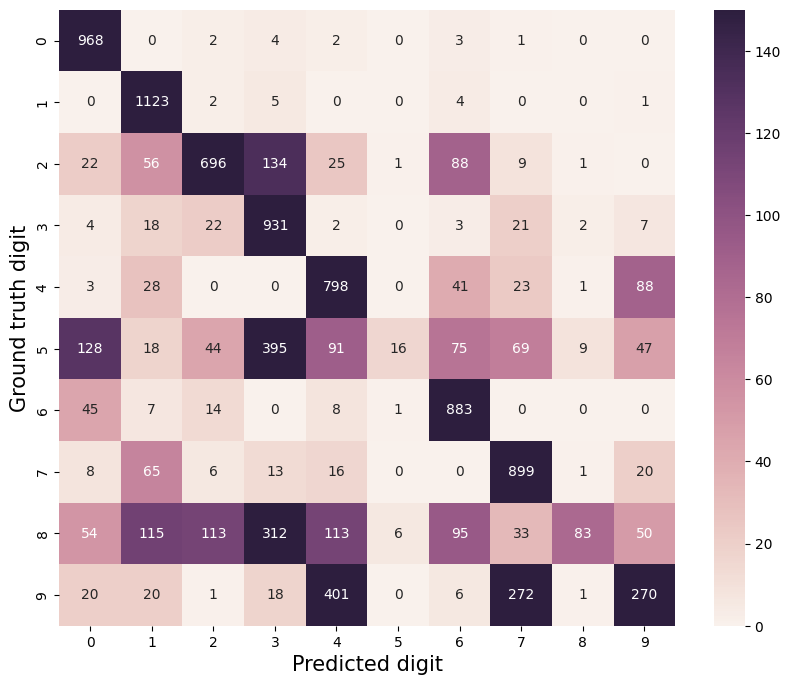

In [9]:
import matplotlib.pyplot as plt
from seaborn import heatmap, cubehelix_palette
from numpy import zeros

# Compute the confusion matrix
def plot_confusion_matrix(model, dataset):
    confusion_matrix = zeros((10, 10))

    predicted_digits = []
    groundtruth_digits = []
    for image, true_digit in dataset:
        probabilities = model(image)
        _, predicted_digit = torch.max(probabilities.data, -1)
        predicted_digits.append(predicted_digit)
        groundtruth_digits.append(true_digit)

    for groundtruth_digit, predicted_digit in zip(groundtruth_digits, predicted_digits):
        confusion_matrix[groundtruth_digit, predicted_digit] += 1 

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap(
        confusion_matrix,
        annot=True, 
        fmt=".0f", 
        square=True, 
        cmap=cubehelix_palette(light=0.95, as_cmap=True),
        vmax=150,
    )
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Ground truth digit", fontsize=15)
    plt.show()
    
plot_confusion_matrix(model, mnist_test)

## Neural network improvements

We now start a journey to improve our network and its training, as is usual in developing machine-learning solutions.
We will gradually introduce some new (and fundametal) concepts, to demonstrate how they affect the performance of the trained network, which provide valuable intuition for what hyperparameters are relevant.

In order to do so we will use the `deeplay` library, which is an superset of `PyTorch` that offers a high-level interface while still allowing low-level access. This will allow us to focus on the concepts rather than the details of the implementation. Since `deeplay` is a superset of `PyTorch`, we can use all the `PyTorch` functions and classes we have already defined.

While `deeplay` may seem overkill for this simple example, it will allow us to easily implement more complex networks later on. 

First, we'll reimplement what we already have. We can base our implementation on the `MultiLayerPerceptron` base class which has the structure we want. It requires at least three arguments:

- `in_features`: the number of input features (can be `None`, which means that the number of input features will be inferred from the first batch of data passed to the network)
- `hidden_features`: a list of integers, each representing the number of neurons in a hidden layer
- `out_features`: the number of output features


In [10]:
import torch
import deeplay as dl

mlp = dl.MultiLayerPerceptron(28 * 28, [32, 32], 10)
mlp

MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [32, 32]
  (out_features): 10
  (depth): 3
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=32, out_features=10, bias=True)
  (out_activation): Identity()
)

However, this model actually uses ReLU activation internally, and has no output activation. Let's change that.

Note the names in the summary that are within parentheses, `in_features`, `hidden_dims` etc. These are the configurable attributes. To change any of the configurable attributes at the base layer (here, `in_features`, `hidden_dims`, `depth`, `blocks`, `out_layer` and `out_activation`), we can simply pass them as inputs to the constructor. Let's change the output activation to sigmoid.

In [11]:
mlp = dl.MultiLayerPerceptron(28 * 28, [32, 32], 10, out_activation=torch.nn.Sigmoid())
print(mlp)

MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [32, 32]
  (out_features): 10
  (depth): 3
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=32, out_features=10, bias=True)
  (out_activation): Sigmoid()
)


However, deeper configurables (such as `(blocks)` -> `(0)` -> `(activation)`) require a configuration object (`dl.Config`). First, let's show how to repeat what we did above with the `dl.Config` object.

In [12]:
mlp_config = (
    dl.Config()
    .in_features(28 * 28)
    .hidden_dims([32, 32])
    .out_features(10)
    .out_activation(torch.nn.Sigmoid)
)

mlp = dl.MultiLayerPerceptron.from_config(mlp_config)
print(mlp)

MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [32, 32]
  (out_features): 10
  (depth): 3
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=32, out_features=10, bias=True)
  (out_activation): Sigmoid()
)


Note that we did not actually create the Sigmoid object. While it would be fine to do so here, sometimes it is not. For example, if the object is used in several places internally, it would use the same object in all places, which is often not what we want. It is always safe to not create objects, and `deeplay` will create them for us when needed.

Now, let's change the activation function of the hidden layers to sigmoid. To do so, we peek at the printout of the model and see that we want to change `blocks` -> `0` -> `activation` and `blocks` -> `1` -> `activation`. We simply mirror this in the configuration object. We can either redefine the configuration object from scratch, or we can simply extend the existing one, as we do here.

In [13]:
mlp_config_with_hidden_sigmoid = (
    mlp_config
    .blocks[0].activation(torch.nn.Sigmoid)
    .blocks[1].activation(torch.nn.Sigmoid)
)

mlp = dl.MultiLayerPerceptron.from_config(mlp_config_with_hidden_sigmoid)
print(mlp)

MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [32, 32]
  (out_features): 10
  (depth): 3
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (normalization): Identity()
      (activation): Sigmoid()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (normalization): Identity()
      (activation): Sigmoid()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=32, out_features=10, bias=True)
  (out_activation): Sigmoid()
)


**Tip!** When indexing, one can omit the index to change all elements of a list. For example, `blocks.activation(torch.nn.Sigmoid)` will change the activation of all blocks. Regular Python slicing also works, so `blocks[:2].activation(torch.nn.Sigmoid)` will change the activation of the first two blocks.

Now our model is identical to the one created in pure torch. 

### Training in deeplay

In `deeplay`, unlike pure `PyTorch`, we typically don't need to write our own training or evaluation logic. Instead, we can train and evaluate models using `Application`, `DataLoader` and `Trainer` objects. `Applications` are deeplay native objects that contain logic specific for the specific task. An example would be `Classifier`, which contains logic specific for classification tasks, including the training logic. `DataLoader` objects are used to load data from a dataset, and are part of the `PyTorch` ecosystem. Finally, `Trainer` objects handle more complex training logic, such deciding what hardware to use, running callbacks, saving the model to disk, and much more. 

We will start with the `Classifier` object.


In [14]:
classifier = dl.Classifier(
    mlp, 
    make_target_onehot=True, # Since we use MSE loss, we need to make the target one-hot, which is when the target is a vector of 0s and 1s.
    loss=torch.nn.MSELoss(),
)
classifier

Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Sigmoid()
  )
  (loss): MSELoss()
  (train_accuracy): Accuracy()
  (val_accuracy): Accuracy()
)

**Note** This object is also configurable in the same way as the `MultiLayerPerceptron` object! In fact, we can just define a single configuration object that defines our entire classifier:

In [15]:
classifier_config = (
    dl.Config()
    .model(dl.MultiLayerPerceptron, mlp_config_with_hidden_sigmoid)
    .make_target_onehot(True)
    .loss(torch.nn.MSELoss)
)

A benefit of doing so is that the optimizer can be configured, which is difficult to do through the constructor. Let's try it out.

In [16]:
classifier_config_with_sgd = (
    classifier_config
    .optimizer(torch.optim.SGD, lr=0.1)
)

classifier = dl.Classifier.from_config(classifier_config_with_sgd)
classifier

Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Sigmoid()
  )
  (loss): MSELoss()
  (train_accuracy): Accuracy()
  (val_accuracy): Accuracy()
)

#### Dataloaders

Next, we define the DataLoaders, one for training and one for testing.

Here, we will introduce our first improvement: _mini-batches_. Mini-batches are a way to train neural networks using only a subset of the training data at each iteration. This is done by splitting the training data into smaller subsets called _mini-batches_. The neural network is then trained on each mini-batch in turn, and the parameters are updated after each mini-batch. In fact, we were already using mini-batches, but we were using a batch size of one. The batch size is a hyperparameter that can be tuned to improve the performance of the neural network. In general, larger batch sizes lead to faster training, but smaller batch sizes lead to better generalization. This is because smaller batch sizes lead to more updates of the parameters, which in turn leads to better generalization. However, smaller batch sizes also lead to slower training, since the parameters are updated more often. In this application, we will use a batch size of 32, which is a good compromise between training speed and generalization.

In [17]:
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False) # We don't need to shuffle the test set

#### Trainers

The trainer handles the training and evaluation. It also handles utilizing the GPU, saving the model, and logging the training and evaluation metrics. We will start by defining a trainer for our model.

Here, we will introduce our second improvement: `epochs`. An epoch is a single pass through the entire training set. In our previous implementation, we were training the neural network for a single epoch. This is not ideal, since the neural network will not have enough time to learn the patterns in the training data. In general, the more epochs we train the neural network for, the better it will perform. However, training for too many epochs can lead to overfitting. Overfitting is when the neural network learns the patterns in the training data too well, and as a result, it performs poorly on the test data. In this application, we will train the neural network for 5 epochs, which is a good compromise between training time and performance.

Since we now have a larger batch size, the training should not be significantly slower, despite training for more epochs.

In [18]:
trainer = dl.Trainer(
    max_epochs=5, # How many times to run through the entire dataset
    accelerator="auto", # Use GPU if available
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


To train, we simply need to call `trainer.fit` as follows:

In [19]:
trainer.fit(classifier, mnist_train_dataloader)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 26.5 K
1 | loss           | MSELoss              | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Let's check the test set. We can reuse the trainer to test the model on the test set:

In [20]:
trainer.test(classifier, mnist_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.9449999928474426     │
│      test_loss_epoch      │   0.008605916053056717    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.008605916053056717,
  'test_accuracy_epoch': 0.9449999928474426}]

Getting the confusion matrix is no different than before:

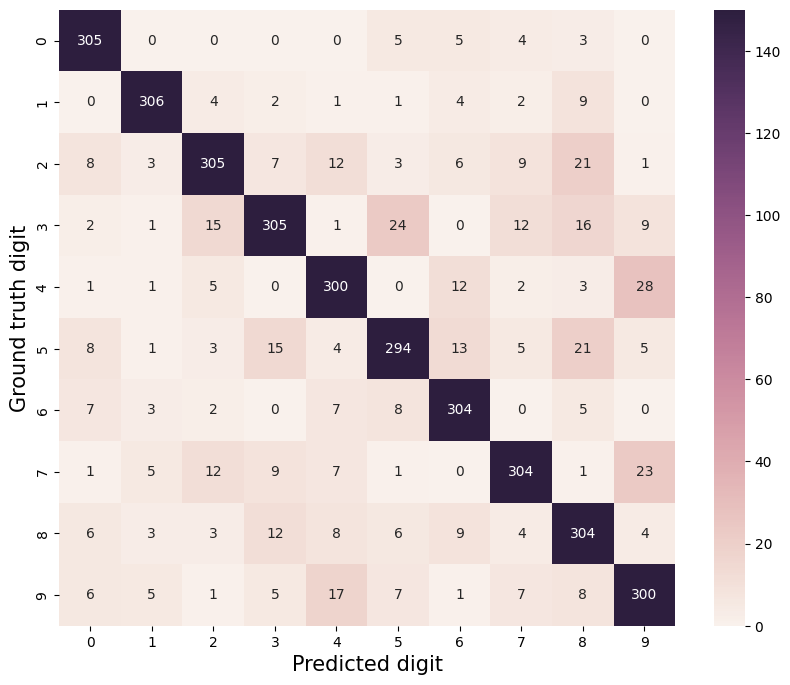

In [21]:
plot_confusion_matrix(classifier, mnist_test_dataloader)

Already much better!

### The choice of optimizer

Using plain _stochastic gradient descent_ for updating weights is straightforward, but generally not optimal. 
Modern deep learning almost universally uses extensions such as _root mean squared propagation_ (RMSprop) or _Adam_. The main advantages of these alternatives are that they change the learning rate for each weight individually during training. Each algorithm has its own way of doing so, but it is common to use some type of _momentum_. For example, a weight that is updated in the same direction multiple times in a row will take larger steps at each iteration, while a weight that changes direction frequently will take smaller steps. We will use _RMSprop_.

In [22]:
classifier_config_with_rms = (
    classifier_config
    .optimizer(torch.optim.RMSprop, lr=0.001)
)

classifier = dl.Classifier.from_config(classifier_config_with_rms)
classifier

Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Sigmoid()
  )
  (loss): MSELoss()
  (train_accuracy): Accuracy()
  (val_accuracy): Accuracy()
)

In [23]:
trainer = dl.Trainer(
    max_epochs=5, # How many times to run through the entire dataset
    accelerator="auto", # For now, we use the cpu. Later, we will use the gpu.
)

trainer.fit(classifier, mnist_train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 26.5 K
1 | loss           | MSELoss              | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [24]:
trainer.test(classifier, mnist_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.9555833339691162     │
│      test_loss_epoch      │   0.0074465349316596985   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.0074465349316596985,
  'test_accuracy_epoch': 0.9555833339691162}]

Another improvement!

### The choice of output activation function

The output representation and loss function can further improve the performance.
As per the output normalization, currently each digit is assigned a probability between 0 and 1 by the network. However, we know that only one classification is true. As such, we can normalize the output such that the prediction sums to one. This is typically done using what is known as _softmax activation_.

We'll complement this with the _cross-entropy loss_, which is a loss function that is commonly used for classification problems. 

However, we cross-entropy loss in `PyTorch` already includes the softmax activation, so we should not apply it twice. We can simply remove the final activation from the model.

Additionally, though not necessary, we can also now set `make_target_one_hot` to `False`. since `CrossEntropyLoss` can handle this internally. Doing so is slightly more efficient.

In [27]:

classifier_config_with_crossentropy = (
    classifier_config_with_rms
    .model.out_activation(torch.nn.Identity)
    .loss(torch.nn.CrossEntropyLoss)
    .make_target_onehot(False)
)

classifier = dl.Classifier.from_config(classifier_config_with_crossentropy)
print(classifier)

Classifier(
  (make_target_onehot): False
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (depth): 3
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Identity()
  )
  (loss): CrossEntropyLoss()
  (train_accuracy): Accuracy()
  (val_accuracy): Accuracy()
)


In [28]:
trainer = dl.Trainer(
    max_epochs=5, # How many times to run through the entire dataset
    accelerator="auto", # For now, we use the cpu. Later, we will use the gpu.
)

trainer.fit(classifier, mnist_train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | MultiLayerPerceptron | 26.5 K
1 | loss           | CrossEntropyLoss     | 0     
2 | train_accuracy | Accuracy             | 0     
3 | val_accuracy   | Accuracy             | 0     
--------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [30]:
trainer.test(classifier, mnist_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │     0.954800009727478     │
│      test_loss_epoch      │    0.14907705783843994    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.14907705783843994,
  'test_accuracy_epoch': 0.954800009727478}]

Another big improvement! Let's look at the confusion matrix.

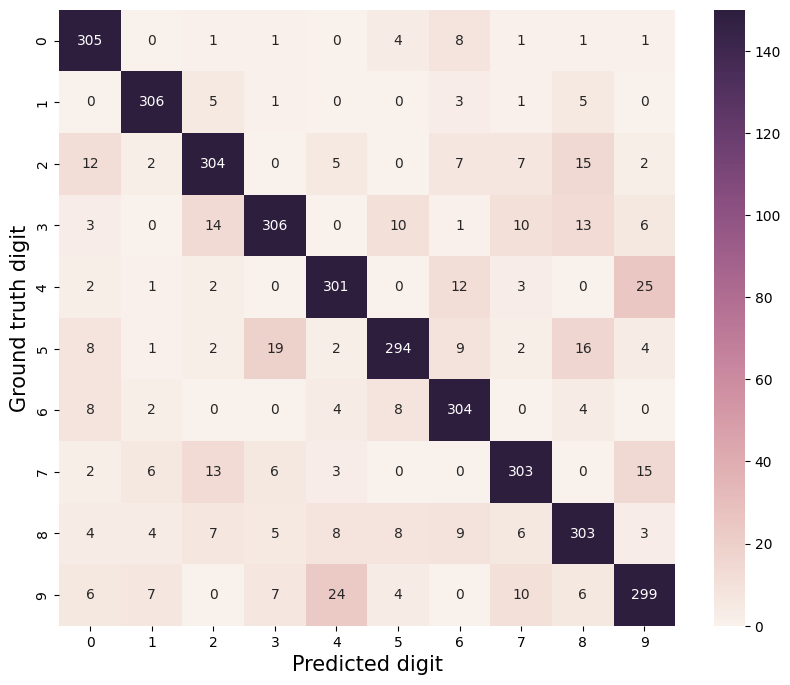

In [32]:
plot_confusion_matrix(classifier, mnist_test_dataloader)